In [1]:
import sys
sys.path.append('..')

import os
import psutil
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
np.random.seed(0)

In [2]:
import matplotlib.pyplot as plt
from pylab import *
from keras.models import Sequential
from keras import optimizers
from keras.models import load_model
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout, Convolution2D, Dense
from keras.models import Model
from keras.datasets import cifar10

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform,he_uniform

from keras.preprocessing.image import ImageDataGenerator
from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from custom_lib.triplet_utils import buildDataSet, build_model
from custom_lib.triplet_utils import get_batch_hard, compute_probs
from custom_lib.triplet_utils import add_top, remove_top

from art.classifiers import KerasClassifier
from art.attacks.projected_gradient_descent import ProjectedGradientDescent
from art.attacks.iterative_method import BasicIterativeMethod
from art.defences.adversarial_trainer import AdversarialTrainer
from art.attacks.fast_gradient import FastGradientMethod

from custom_lib.build_resnet import resnet_v1, resnet_emb

Using TensorFlow backend.


In [3]:
def restrict_cpu():
    p = psutil.Process()

    for i in p.threads():
        temp = psutil.Process(i.id)

        temp.cpu_affinity([i for i in range(10)])

In [4]:
learning_rate = 5e-6
batch_size=64
epochs=10

nb_classes = 10
img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)
in_shape = input_shape

In [5]:
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


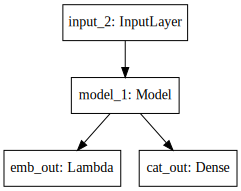

In [6]:
# -------------------- Base Model --------------------------

base_model = resnet_emb(input_shape)
base_model.load_weights("saved_models/old_base.h5")

base_in = Input(shape=in_shape)
base_out = base_model(base_in)

# -------------------- Emb Model ---------------------------

emb_branch = Lambda(lambda t: K.l2_normalize(t,axis=-1), name="emb_out")(base_out)
#emb_branch = Lambda(lambda t: t, name="emb_out")(base_out)
                                                  
# -------------------- Categorical Model -------------------

cat_branch = Dense(10, activation='softmax', name="cat_out")(base_out)

# -------------------- Compile -----------------------------

model = Model(inputs=base_in, 
              outputs=[emb_branch, cat_branch], 
              name="fullnet")

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [7]:
def euclidean_distance_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [26]:
losses = {
    "emb_out": euclidean_distance_loss,
    "cat_out": "categorical_crossentropy",
}

lossWeights = {"emb_out": 5, "cat_out": 0.2}

#model.compile(optimizer=RMSprop(lr=5e-4), loss=losses, loss_weights=lossWeights, metrics=["accuracy"])
model.compile(optimizer=Adam(lr=5e-4), loss=losses, loss_weights=lossWeights, metrics=["accuracy"])

In [9]:
b_in = Input(shape=in_shape)
b_out = model(b_in)[1]

adv_model = Model(inputs=b_in, outputs=b_out)
adv_model.compile(loss="categorical_crossentropy", optimizer=Adam(1e-3), metrics=["accuracy"])

In [10]:
dummy_train = np.zeros(shape=(x_train.shape[0], 128))
dummy_test = np.zeros(shape=(x_test.shape[0], 128))

model.fit(x_train, [dummy_train, y_train],
          validation_data=(x_test, [dummy_test, y_test]),
          epochs=1, 
          batch_size=32,
          verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 81s 2ms/step - loss: 0.2801 - emb_out_loss: 1.0000 - cat_out_loss: 0.3280 - emb_out_acc: 0.0000e+00 - cat_out_acc: 0.8944 - val_loss: 0.2942 - val_emb_out_loss: 1.0000 - val_cat_out_loss: 0.3521 - val_emb_out_acc: 0.0000e+00 - val_cat_out_acc: 0.8820


In [11]:
art_model = KerasClassifier(clip_values=(0, 1.), model=adv_model, use_logits=False)
attack = ProjectedGradientDescent(art_model, norm=2, eps=8, random_eps=True, eps_step=2, max_iter=5, batch_size=16)

adv_test = attack.generate(x_test[:10])

restrict_cpu()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [12]:
emb_train = model.predict(x_train)[0]
emb_test = model.predict(x_test)[0]

In [13]:
#print(attack.classifier._model.layers[1].layers[1].layers[-8].get_weights()[0][0, 0, :4, :4])

In [21]:
def batch_generator(X, Y, batch_size = 64):
    
    indices = np.arange(len(X))
    
    batch=[]
    while True:
            # it might be a good idea to shuffle your data before each epoch
            np.random.shuffle(indices) 
            for i in indices:
                batch.append(i)
                if len(batch)==batch_size:
                    adv_x = X[batch]
                    VAL = model.predict(adv_x)[0]
                    adv_x[:48] = attack.generate(adv_x[:48])
                    yield adv_x, [VAL, Y[batch]]
                    batch=[]

train_generator = batch_generator(x_train, y_train, batch_size = 64)

In [27]:
def batch_generator(X, Y, batch_size = 64):
    
    indices = np.arange(len(X))
    
    batch=[]
    while True:
            # it might be a good idea to shuffle your data before each epoch
            np.random.shuffle(indices) 
            for i in indices:
                batch.append(i)
                if len(batch)==batch_size:
                    adv_x = X[batch]
                    VAL = model.predict(adv_x)[0]
                    adv_x = attack.generate(adv_x)
                    
                    x_full = np.concatenate((X[batch], adv_x), axis=0)
                    e_full = np.concatenate((VAL, VAL), axis=0)
                    y_full = np.concatenate((Y[batch], Y[batch]), axis=0)
                    
                    yield x_full, [e_full, y_full]
                    batch=[]

train_generator = batch_generator(x_train, y_train, batch_size = 64)

In [19]:
batch = train_generator.__next__()

loss = model.evaluate(batch[0], batch[1], verbose=0)

for i, l in enumerate(model.metrics_names):
    print(l, loss[i])

loss 2.0667241252958775
emb_out_loss 0.5259471535682678
cat_out_loss 7.638870066031814
emb_out_acc 0.5546875
cat_out_acc 0.5


In [ ]:
# Hyper parameters
evaluate_every = 125 # interval for evaluating on one-shot tasks
n_iter = 16_000 # No. of training iterations
n_val = 250 # how many one-shot tasks to validate on
n_iteration=0

loss_list = []
total_loss = []

emb_vals = []
cat_vals = []
acc_vals = []

print("Starting training process!")
print("-------------------------------------")

t_start = time.time()

for i in range(1, n_iter+1):
    
    batch = train_generator.__next__()
    
    loss = model.train_on_batch(batch[0], batch[1])
    
    emb_vals.append(loss[1])
    cat_vals.append(loss[2])
    acc_vals.append(loss[4])
    
    n_iteration += 1
    
    if i % 4000 == 0:
        K.set_value(model.optimizer.lr, K.get_value(model.optimizer.lr)/2.0)
    
    if i % evaluate_every == 0:
        ploss = (np.mean(emb_vals), np.mean(cat_vals), np.mean(acc_vals))
        loss_list.append(ploss)
        emb_vals = []
        cat_vals = []
        acc_vals = []
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(i, (time.time()-t_start)/60.0,ploss,n_iteration))

Starting training process!
-------------------------------------

 ------------- 

[125] Time for 125 iterations: 1.3 mins, Train Loss: (0.010755617, 0.9395914, 0.677)

 ------------- 

[250] Time for 250 iterations: 2.3 mins, Train Loss: (0.008307475, 0.91911167, 0.6826875)

 ------------- 

[375] Time for 375 iterations: 3.3 mins, Train Loss: (0.007650793, 0.9356564, 0.66975)

 ------------- 

[500] Time for 500 iterations: 4.3 mins, Train Loss: (0.008966271, 0.90459025, 0.6858125)

 ------------- 

[625] Time for 625 iterations: 5.3 mins, Train Loss: (0.0073885294, 0.92321527, 0.678875)

 ------------- 

[750] Time for 750 iterations: 6.3 mins, Train Loss: (0.008228601, 0.909911, 0.684125)

 ------------- 

[875] Time for 875 iterations: 7.2 mins, Train Loss: (0.094695516, 1.1937257, 0.603625)

 ------------- 

[1000] Time for 1000 iterations: 8.2 mins, Train Loss: (0.026592605, 1.8639022, 0.3404375)

 ------------- 

[1125] Time for 1125 iterations: 9.3 mins, Train Loss: (0.0367829

In [25]:
batch = train_generator.__next__()

loss = model.evaluate(batch[0], batch[1], verbose=0)

for i, l in enumerate(model.metrics_names):
    print(l, loss[i])

loss 0.4125548377633095
emb_out_loss 0.015087807085365057
cat_out_loss 1.7668695077300072
emb_out_acc 1.0
cat_out_acc 0.4765625


In [21]:
eval_loss = adv_model.evaluate(x_test, y_test, verbose=0)

print("Base images:")
for i, name in enumerate(adv_model.metrics_names):
    print(name, eval_loss[i])

losses = []
accs = []


for i in range(0, 8000, 32):
    adv_test = attack.generate(x_test[i:i+32])
    eval_loss = adv_model.evaluate(adv_test, y_test[i:i+32], verbose=0)
    losses.append(eval_loss[0])
    accs.append(eval_loss[1])

print("\nAdv images:")
print('loss', np.mean(losses))
print('acc', np.mean(accs))

Base images:
loss 0.5653817445755005
acc 0.8494

Adv images:
loss 2.0614436777830125
acc 0.2865
